Centroides dos clusters:
         Água    Celular         Luz    Internet      Aluguel      Cartão  \
0  109.130435  73.043478  145.217391  104.782609  1130.434783  626.086957   
1  108.518519  71.111111  146.666667  102.962963  1611.111111  633.333333   
2  109.629630  48.888889  151.851852  103.333333   888.888889  457.407407   
3  111.739130  46.956522  156.521739  107.826087  1369.565217  452.173913   

        Lazer     Apostas  Emprego Fixo       Bicos  
0  249.130435  330.434783   3652.173913  417.391304  
1  393.333333  311.111111   6055.555556  500.000000  
2  176.666667   88.888889   2444.444444  422.222222  
3  320.869565   69.565217   4847.826087  456.521739  


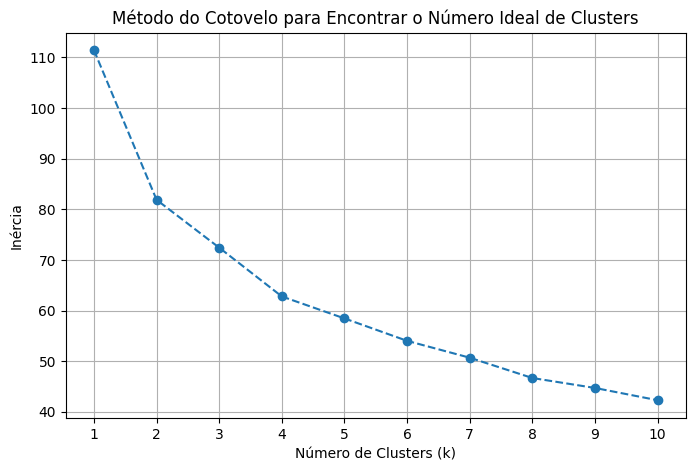

Novo usuário gerado: {'Água': 128, 'Celular': 80, 'Luz': 194, 'Internet': 120, 'Aluguel': 1686, 'Cartão': 376, 'Lazer': 363, 'Apostas': 14, 'Emprego Fixo': 3443, 'Bicos': 306}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


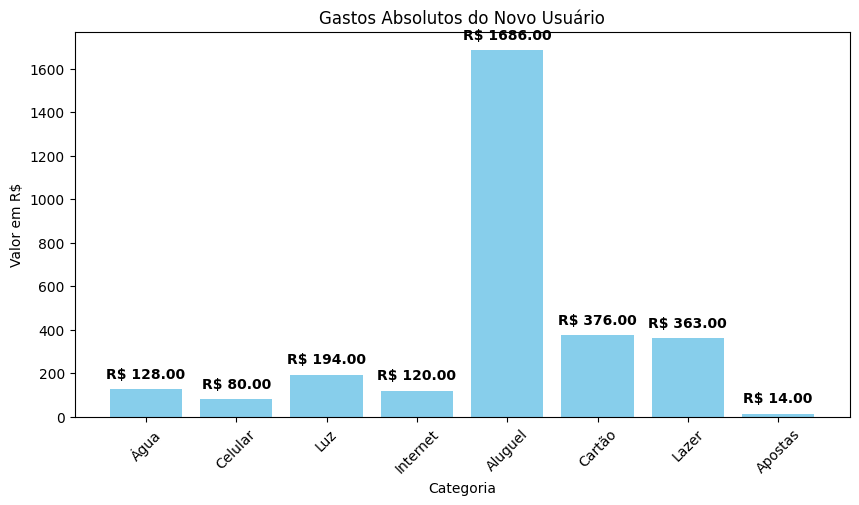

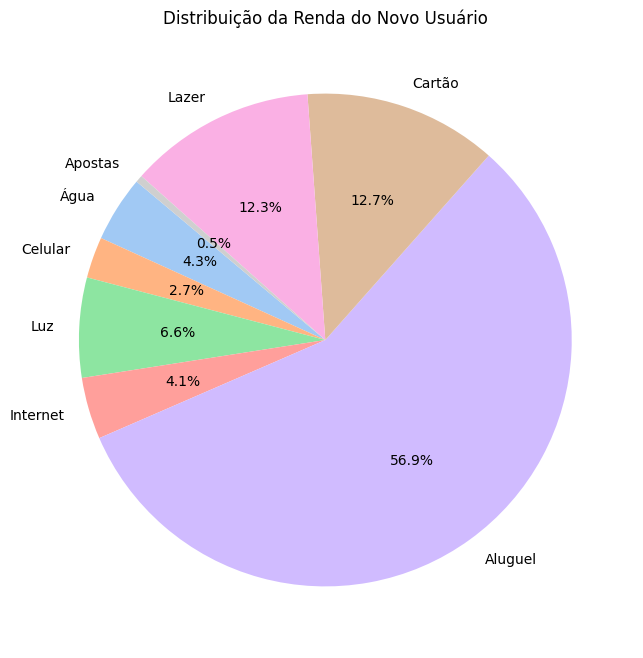

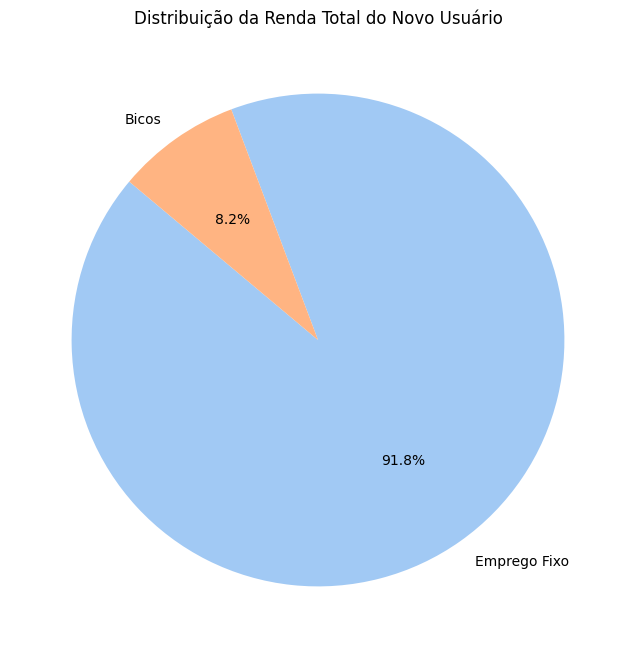

O novo usuário pertence ao cluster 3: Corrido: Gasta muito com finanças necessárias, não desperdiça e tem pouco dinheiro sobrando.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Carregar os dados
dataframe = pd.read_excel('Analíse_relaçao_economiasEgastos.xlsx')

# Selecionar apenas as colunas relevantes para análise (excluindo 'Usuário')
features = ['Água', 'Celular', 'Luz', 'Internet', 'Aluguel', 'Cartão', 'Lazer', 'Apostas', 'Emprego Fixo', 'Bicos']
dataframe = dataframe[features]

# Obter os valores mínimos e máximos de cada feature
min_values = dataframe.min()
max_values = dataframe.max()

# Normalizar os dados
scaler = MinMaxScaler()
dataframe_normalizadoGeral = pd.DataFrame(scaler.fit_transform(dataframe), columns=features)

# Número ideal de clusters (agora 4)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
dataframe_normalizadoGeral['Cluster'] = kmeans.fit_predict(dataframe_normalizadoGeral)

# Os centróides
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Centroides dos clusters:")
print(centroids)

# Gráfico do método do cotovelo
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_tmp.fit(dataframe_normalizadoGeral[features])
    inertias.append(kmeans_tmp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Encontrar o Número Ideal de Clusters')
plt.xticks(k_values)
plt.grid()
plt.show()

# Descrições dos clusters
descricao_clusters = {
    0: "Econômico: Gasta pouco e economiza bem, mas falta investir.",
    1: "Equilibrado: Gasta de forma controlada e mantém uma boa organização financeira.",
    2: "Gastador: Gasta muito e pode ter desperdícios, precisa de mais controle financeiro.",
    3: "Corrido: Gasta muito com finanças necessárias, não desperdiça e tem pouco dinheiro sobrando."
}

# KNN para classificação de novos usuários
knn = KNeighborsClassifier(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(
    dataframe_normalizadoGeral[features], dataframe_normalizadoGeral['Cluster'], test_size=0.2, random_state=42
)
knn.fit(X_train, y_train)

# Regressão logística para previsão de clusters
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

def gerar_usuario_aleatorio():
    return {feature: np.random.randint(min_values[feature], max_values[feature] + 1) for feature in features}

def classificar_novo_usuario(novo_usuario):
    novo_usuario_df = pd.DataFrame([novo_usuario], columns=features)
    novo_usuario_normalizado = scaler.transform(novo_usuario_df)
    cluster_predito = knn.predict(novo_usuario_normalizado)[0]

    # Calcular orçamento total
    orcamento_total = novo_usuario['Emprego Fixo'] + novo_usuario['Bicos']
    despesas = {k: v for k, v in novo_usuario.items() if k not in ['Emprego Fixo', 'Bicos']}
    despesas_percentuais = {k: (v / orcamento_total) * 100 for k, v in despesas.items()}

    # Gráficos
    plt.figure(figsize=(10, 5))
    plt.bar(despesas.keys(), despesas.values(), color='skyblue')
    plt.xlabel('Categoria')
    plt.ylabel('Valor em R$')
    plt.title('Gastos Absolutos do Novo Usuário')
    plt.xticks(rotation=45)
    for i, (categoria, valor) in enumerate(despesas.items()):
        plt.text(i, valor + 50, f'R$ {valor:.2f}', ha='center', fontsize=10, fontweight='bold')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.pie(despesas_percentuais.values(), labels=despesas_percentuais.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Distribuição da Renda do Novo Usuário')
    plt.show()

    renda = {'Emprego Fixo': novo_usuario['Emprego Fixo'], 'Bicos': novo_usuario['Bicos']}
    plt.figure(figsize=(8, 8))
    plt.pie(renda.values(), labels=renda.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Distribuição da Renda Total do Novo Usuário')
    plt.show()

    print(f"O novo usuário pertence ao cluster {cluster_predito}: {descricao_clusters[cluster_predito]}")
    return cluster_predito, descricao_clusters[cluster_predito]

# Gerar um novo usuário aleatório e classificá-lo
novo_usuario = gerar_usuario_aleatorio()
print("Novo usuário gerado:", novo_usuario)
cluster_resultado, descricao = classificar_novo_usuario(novo_usuario)
